__This notebook__ compares PCA, MDS and Probabilistic Differentiable Graph Embeddings for the task of isometric compression

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
sys.path.insert(0, "..")
import lib
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import trange
from IPython.display import clear_output

In [2]:
if not os.path.exists("./Pinterest"):
    !wget https://www.dropbox.com/s/gtlafw4kp77d7nl/pinterest.tar.gz?dl=1 -O pinterest.tar.gz
    !tar -xvzf pinterest.tar.gz
    !rm pinterest.tar.gz

from lib.task.colaborative.pinterest import Dataset
data = Dataset("./Pinterest/pinterest-20")
matrix = data.trainMatrix.tocsr().sorted_indices()

positives = {i: matrix.getrow(i).nonzero()[1] for i in trange(matrix.shape[0])}
num_users, num_items = matrix.shape

100%|██████████| 55187/55187 [00:10<00:00, 5111.26it/s]


In [3]:
from lib.task.colaborative import make_graph_colaborative
emb = make_graph_colaborative(
       matrix.toarray(), knn_edges=16, score_to_distance=lambda x: 1. / x, verbose=True,
       max_length=10, n_jobs=-1, soft=True, k_nearest=0, directed=False,
)

def user_to_vertex(ix):
    return torch.as_tensor(ix) + num_items

def item_to_vertex(ix):
    return torch.as_tensor(ix)

Mining nearest neighbors...
Assembling user-item edges...
Deduplicating edges...
Total edges: 2216472, mean edges per vertex: 34.045620017510714, mean distance: 0.925434434153916


In [ ]:
loss_history, reg_history, recall_history = [], [], []

total_edges = emb.num_edges
stage = 0
num_positives = 10
k_nearest = 256
num_negatives = 100
skip_negatives = 10
batch_size = 64
opt = None

def update_learning_rate():
    t = len(loss_history)
    global opt, stage, emb, batch_size
    
    if stage == 0:
        opt = torch.optim.SparseAdam(emb.parameters(), lr=0.1)
        stage += 1
        
    if stage == 1 and t >= 5000:
        emb = emb.pruned(threshold=0.5)
        opt = torch.optim.SparseAdam(emb.parameters(), lr=0.05)
        stage += 1
    
    if stage == 2 and t >= 10000:
        emb = emb.pruned(threshold=0.1)
        opt = torch.optim.SparseAdam(emb.parameters(), lr=0.01)
        stage += 1


def eval_recall(batch_size=batch_size, k=10):
    user_ix, pos_items = map(torch.tensor, zip(*data.testRatings))
    assert torch.all(user_ix == torch.arange(num_users)).item()
    neg_items = torch.as_tensor(data.testNegatives)

    ix = torch.randint(num_users, size=[batch_size])
    user_ix, pos_items, neg_items = user_ix[ix], pos_items[ix], neg_items[ix]
    pos_and_neg = torch.cat([pos_items[:, None], neg_items], dim=1)
    pred_pos_and_neg = emb(user_to_vertex(user_ix), item_to_vertex(pos_and_neg), deterministic=True)
    ordered = pred_pos_and_neg['target_distances'].data.numpy().argsort(-1)
    positive_indices = np.array([list(row).index(0) for row in ordered])
    return np.mean(positive_indices < k)

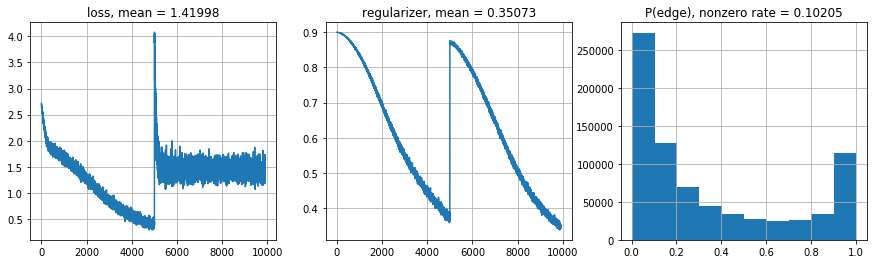

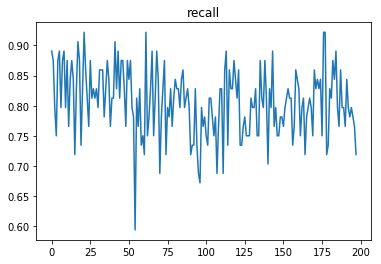

Reached target compression rate, exiting


In [5]:
for batch_i in range(len(loss_history), 100000):
    print(end='.')
    update_learning_rate()
    users = torch.randint(0, num_users, (batch_size,))
    items_positive = torch.as_tensor(
        [np.random.choice(positives[i], replace=num_positives > len(positives[i]), size=num_positives)
         for i in lib.check_numpy(users)], dtype=torch.int32)
    
    items_negative = torch.randint(0, num_items, size=(batch_size, num_negatives), dtype=torch.int32)
    items_posneg = torch.cat([items_positive, items_negative], dim=-1)
    
    pred = emb(user_to_vertex(users), item_to_vertex(items_posneg), max_steps=10 ** 5)
    distances_positive = pred['target_distances'][:, :num_positives]
    distances_negative = pred['target_distances'][:, num_positives:]
    log_numerator = -distances_positive
    logaddexp_negatives = torch.logsumexp(-distances_negative, dim=-1)
    log_denominator = torch.log(torch.exp(log_numerator) + \
                                torch.exp(logaddexp_negatives)[:, None])
    loss = torch.mean(-log_numerator + log_denominator)
    
    
    regularizer = emb.compute_l0_prior_penalty(batch_size=4096)
    lambd = min(1, len(loss_history) / 10000.) * (emb.num_edges / total_edges) * 20.0
    obj = loss - pred['logp_target_paths'][:, :num_positives].mean() + lambd * regularizer
            
    opt.zero_grad()
    obj.backward()
    opt.step()
    loss_history.append(loss.item())
    reg_history.append(regularizer.item())
    
    if len(loss_history) % 50 == 0:
        recall = eval_recall()
        recall_history.append(float(recall))
        
        clear_output(True)
        plt.figure(figsize=[15, 4])
        plt.subplot(1, 3, 1);
        plt.title('loss, mean = %0.5f' % np.mean(loss_history[-100:])); plt.grid()
        plt.plot(loss_history)
        
        plt.subplot(1, 3, 2);
        plt.title('regularizer, mean = %0.5f' % np.mean(reg_history[-100:])); plt.grid()
        plt.plot(reg_history)

        plt.subplot(1, 3, 3);
        probs = torch.sigmoid(emb.edge_adjacency_logits).data.numpy().ravel()
        plt.title('P(edge), nonzero rate = %.5f' % (np.sum(probs > 0.5) / total_edges))
        plt.grid();
        plt.hist(probs)
        plt.show()
        
        plt.title('recall')
        plt.plot(recall_history)
        plt.show()
        
        if emb.report_model_size()['num_parameters'] / (num_users + num_items) < 8.0: 
            print("Reached target compression rate, exiting")
            break

# batch/s rate will increase at 5k and 10k steps

### Evaluate

In [23]:
user_ix, pos_items = map(torch.tensor, zip(*data.testRatings))
assert torch.all(user_ix == torch.arange(num_users)).item()
neg_items = torch.as_tensor(data.testNegatives)
pos_and_neg = torch.cat([pos_items[:, None], neg_items], dim=1)

In [24]:
emb_pruned = emb.pruned()

In [25]:
positive_indices = []
for batch_start in range(0, num_users, batch_size):
    print(end='.')
    batch = slice(batch_start, batch_start + batch_size)
    pred_pos_and_neg = emb_pruned(user_to_vertex(user_ix)[batch], item_to_vertex(pos_and_neg)[batch],
                                  deterministic=True)
    ordered = pred_pos_and_neg['target_distances'].data.numpy().argsort(-1)
    positive_indices.extend(np.array([list(row).index(0) for row in ordered]))

...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [26]:
np.mean(np.array(positive_indices) < 5)

0.6340080091325856

In [27]:
np.mean(np.array(positive_indices) < 10)

0.8077626977367859

In [28]:
print("params per vertex = %.4f" % (emb_pruned.report_model_size()['num_parameters'] / (num_users + num_items)))

params per vertex = 7.9488
